In [2]:
import numpy as np
import pandas as pd
import math
import re
import string
from google.cloud import bigquery
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go


In [4]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

client = bigquery.Client(location="US", project="helio-staging")

Client creating using default project: helio-staging


In [120]:
NORMALIZED_URL_LI = [
    "lovekinship.com",
    "livetinted.com",
    "blume.com",
    "lolibeauty.com",
    "beekman1802.com",
    "fifthandroot.com",
    "theroutebeauty.com",
    "cannuka.com",
    "zitsticka.com",
    "uomabeauty.com",
    "lovewellness.com",
    "tula.com"
]

PRIMARY_CATEGORIES = [
    'Skincare',
]                      


BRAND_NAME_LI = [
    "Kinship",
    "Live Tinted",
    "Blume",
    "LOLI Beauty",
    "Beekman 1802",
    "fith & root",
    "The Route",
    "Cannuka",
    "ZitSticka",
    "Uoma Beauty",
    "Love Wellness",
    "Tula Skincare"
]
brand_name_di = dict(zip(NORMALIZED_URL_LI,BRAND_NAME_LI))
retailer = ["ulta", "credo"]

In [121]:
job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
            bigquery.ArrayQueryParameter("retailers", "STRING", retailer)
        ]
)
max_date_query = """
    SELECT max(execution_date)
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    where execution_date > DATE_ADD(current_date(), INTERVAL -10 DAY)
    and normalized_url IS NOT NULL
    """
query_job = client.query(
    max_date_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

max_date = query_job.to_dataframe()['f0_'].astype('str')[0]

In [122]:
max_date

'2022-03-14'

In [164]:

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("url", "STRING", NORMALIZED_URL_LI),
        bigquery.ScalarQueryParameter("max_date", "STRING", max_date),
        bigquery.ArrayQueryParameter("retailers", "STRING", retailer)
    ]
)
review_query = """
    SELECT source_name,
    normalized_url,
    review_source_id,
    reviewer_source_id,
    product_name,
    product_source_id,
    review_date,
    review_rating,
    review_content
    FROM `helio-staging.online_reviews.online_reviews__deduped_review__1_0`
    WHERE normalized_url IN UNNEST (@url)
    AND source_name in UNNEST (@retailers)
    AND execution_date = @max_date
    """
query_job = client.query(
    review_query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
    job_config=job_config
)  # API request - starts the query

reviews = query_job.to_dataframe()
reviews = reviews.loc[reviews.astype(str).drop_duplicates().index]


In [161]:
reviews_ulta = reviews[reviews["source_name"]=="ulta"]
reviews_credo = reviews[reviews["source_name"]=="credo"]


In [162]:
import datetime

In [172]:
ulta_data = reviews_ulta.groupby("normalized_url")["review_date"].value_counts()
ulta_data = ulta_data.reset_index(name = "count").sort_values("review_date")
ulta_data.set_index("review_date", inplace=True)
ulta_data ["cumulative"]=ulta_data.groupby("normalized_url")["count"].cumsum()
ulta_data = ulta_data.reset_index()
ulta_data["Brand"] = ulta_data["normalized_url"].map(brand_name_di)
ulta_data['review_date'] = pd.to_datetime(ulta_data['review_date'])

ulta_data = ulta_data[ulta_data["review_date"]>="2019-01-01"]

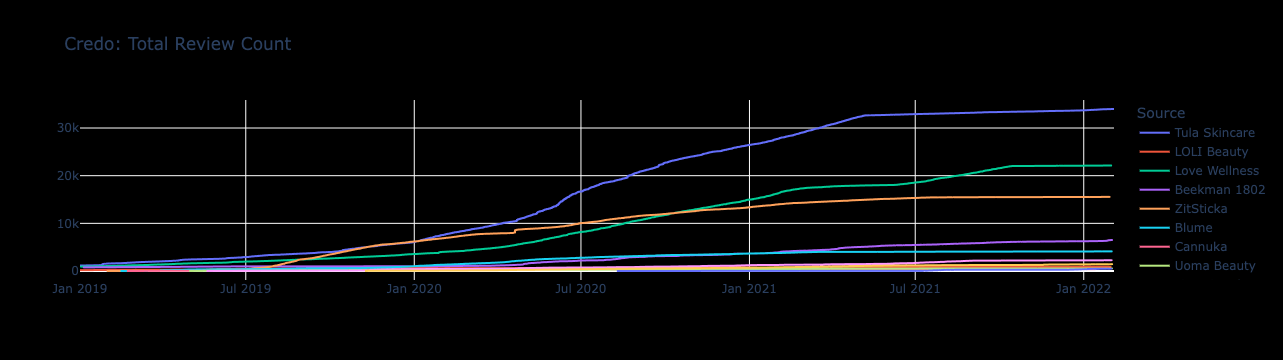

In [185]:
ulta_data_fig = px.line(ulta_data, x="review_date", y="cumulative", color='Brand', title = "Credo: Total Review Count")

ulta_data_fig.update_layout(xaxis_title = "", yaxis_title = "",paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', legend_title = "Source",legend = dict(bgcolor = 'rgba(0,0,0,0)'))

ulta_data_fig.show()

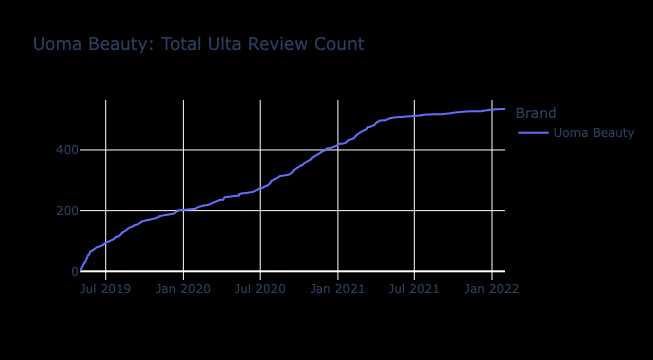

In [194]:
brand = "Uoma Beauty"

ulta_data_fig = px.line(ulta_data[ulta_data["Brand"]== brand], x="review_date", y="cumulative", color='Brand', title = brand + ": Total Ulta Review Count")

ulta_data_fig.update_layout(xaxis_title = "", yaxis_title = "",paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', legend_title = "Brand",legend = dict(bgcolor = 'rgba(0,0,0,0)'))

ulta_data_fig.show()

In [178]:
credo_data = reviews_credo.groupby("normalized_url")["review_date"].value_counts()
credo_data = credo_data.reset_index(name = "count").sort_values("review_date")
credo_data.set_index("review_date", inplace=True)
credo_data ["cumulative"]=credo_data.groupby("normalized_url")["count"].cumsum()
credo_data = credo_data.reset_index()
credo_data["Brand"] = credo_data["normalized_url"].map(brand_name_di)
credo_data['review_date'] = pd.to_datetime(credo_data['review_date'])

credo_data = credo_data[credo_data["review_date"]>="2019-01-01"]

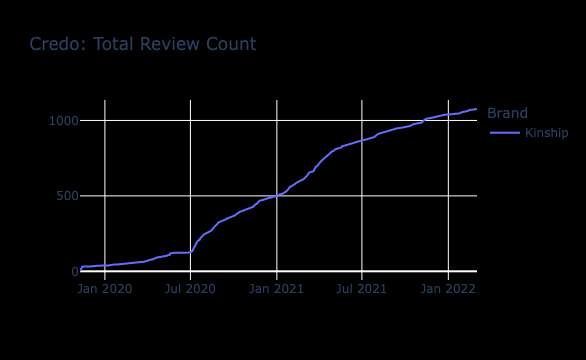

In [183]:
credo_data_fig = px.line(credo_data, x="review_date", y="cumulative", color='Brand', title = "Credo: Total Review Count")

credo_data_fig.update_layout(xaxis_title = "", yaxis_title = "",paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', legend_title = "Brand",legend = dict(bgcolor = 'rgba(0,0,0,0)'))

credo_data_fig.show()

In [130]:
kinship_rev_source_counts = reviews[reviews["normalized_url"]=="lovekinship.com"].groupby("source_name")["review_date"].value_counts()

In [131]:
kinship_rev_source_counts = kinship_rev_source_counts.reset_index(name = "count").sort_values("review_date")

In [132]:
kinship_rev_source_counts.set_index("review_date", inplace=True)


In [133]:
kinship_rev_source_counts ["cumulative"]=kinship_rev_source_counts.groupby("source_name")["count"].cumsum()

In [134]:
fig = px.line(kinship_rev_source_counts, x="review_date", y="cumulative", color='source_name', title = "Kinship: Total Review Count")

fig.update_layout(xaxis_title = "", yaxis_title = "",paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', legend_title = "Source",legend = dict(bgcolor = 'rgba(0,0,0,0)'))

fig.show()


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['source_name', 'count', 'cumulative'] but received: review_date

In [ ]:
#kinship most frequent words 

In [ ]:
#ulta vs credo tf-idf

In [ ]:
#competitor reviews overtime



In [ ]:
#competitor TF-idf